I am following and playing with the area segmentation workflow described here: https://blog.dask.org/2021/03/19/image-segmentation

Read in the data as a Dask array

reading in 72 stacks of 2048^2 88 slices (72, 88, 2048, 2048) consumed 50 GB of memory and take 22 minutes. 

In [9]:
import os
import shutil
import numpy as np 
from tifffile import imread

full_array = np.zeros((72, 88, 2048, 2048), dtype='uint16')
my_dir = '/Volumes/Extreme Pro/20220316_125052_CntrlEmb/0_right_side_only/'
images = [item for item in os.listdir(my_dir) if not item.startswith('.')]
images.sort()

for index, image in enumerate(images):
    full_array[index] = imread(my_dir + image)
    print(f'{round(index/len(images)*100, 2)}% finished reading')

0.0% finished reading
1.39% finished reading
2.78% finished reading
4.17% finished reading
5.56% finished reading
6.94% finished reading
8.33% finished reading
9.72% finished reading
11.11% finished reading
12.5% finished reading
13.89% finished reading
15.28% finished reading
16.67% finished reading
18.06% finished reading
19.44% finished reading
20.83% finished reading
22.22% finished reading
23.61% finished reading
25.0% finished reading
26.39% finished reading
27.78% finished reading
29.17% finished reading
30.56% finished reading
31.94% finished reading
33.33% finished reading
34.72% finished reading
36.11% finished reading
37.5% finished reading
38.89% finished reading
40.28% finished reading
41.67% finished reading
43.06% finished reading
44.44% finished reading
45.83% finished reading
47.22% finished reading
48.61% finished reading
50.0% finished reading
51.39% finished reading
52.78% finished reading
54.17% finished reading
55.56% finished reading
56.94% finished reading
58.33

In [1]:
import napari
%gui qt
viewer = napari.Viewer()

In [2]:
from tifffile import imread
impath = '/Volumes/Extreme Pro/20220316_125052_CntrlEmb/0_right_side_only/S000_t000002_V000_R0000_X000_Y000_C00_I1_D0_P00088.tif'
test_im = imread(impath)

In [3]:
aspect_xz = 2.5 / 0.4
viewer.add_image(test_im, scale=(aspect_xz, 1,1))

<Image layer 'test_im' at 0x1bf94a4f0>

In [21]:
#from dask_image.imread import imread
import dask.array.image
from pathlib import Path
base = Path.cwd()
images = dask.array.image.imread('/Volumes/Extreme Pro/20220316_125052_CntrlEmb/0_right_side_only/*.tif') # Dask array type, with shape (200, 520, 696) (images, ydim, xdim)

In [22]:
images

,Array,Chunk
Bytes,49.50 GiB,704.00 MiB
Shape,"(72, 88, 2048, 2048)","(1, 88, 2048, 2048)"
Count,72 Tasks,72 Chunks
Type,uint16,numpy.ndarray


In [26]:

print(test.shape)

(72, 88, 2048, 2048)


In [17]:
import napari
%gui qt
viewer = napari.Viewer()

In [23]:
viewer.add_image(images)

<Image layer 'images' at 0x1ca74c8b0>

Pre-process the data (here we will just smooth):

In [2]:
from dask_image import ndfilters
smoothed = ndfilters.gaussian_filter(images, sigma=[0, 1, 1])
# smoothed is a Dask array of the smoothed images

Let's try an absolute threshold, and display the results in Napari:

In [3]:
import napari
%gui qt
viewer = napari.Viewer()
absolute_threshold = smoothed > 160
viewer.add_image(absolute_threshold, opacity = 0.5)
viewer.add_image(images, contrast_limits=[0, 2000], blending='additive')

<Image layer 'images' at 0x10f670ee0>

This works okay, but not great, and NOT equally for all images

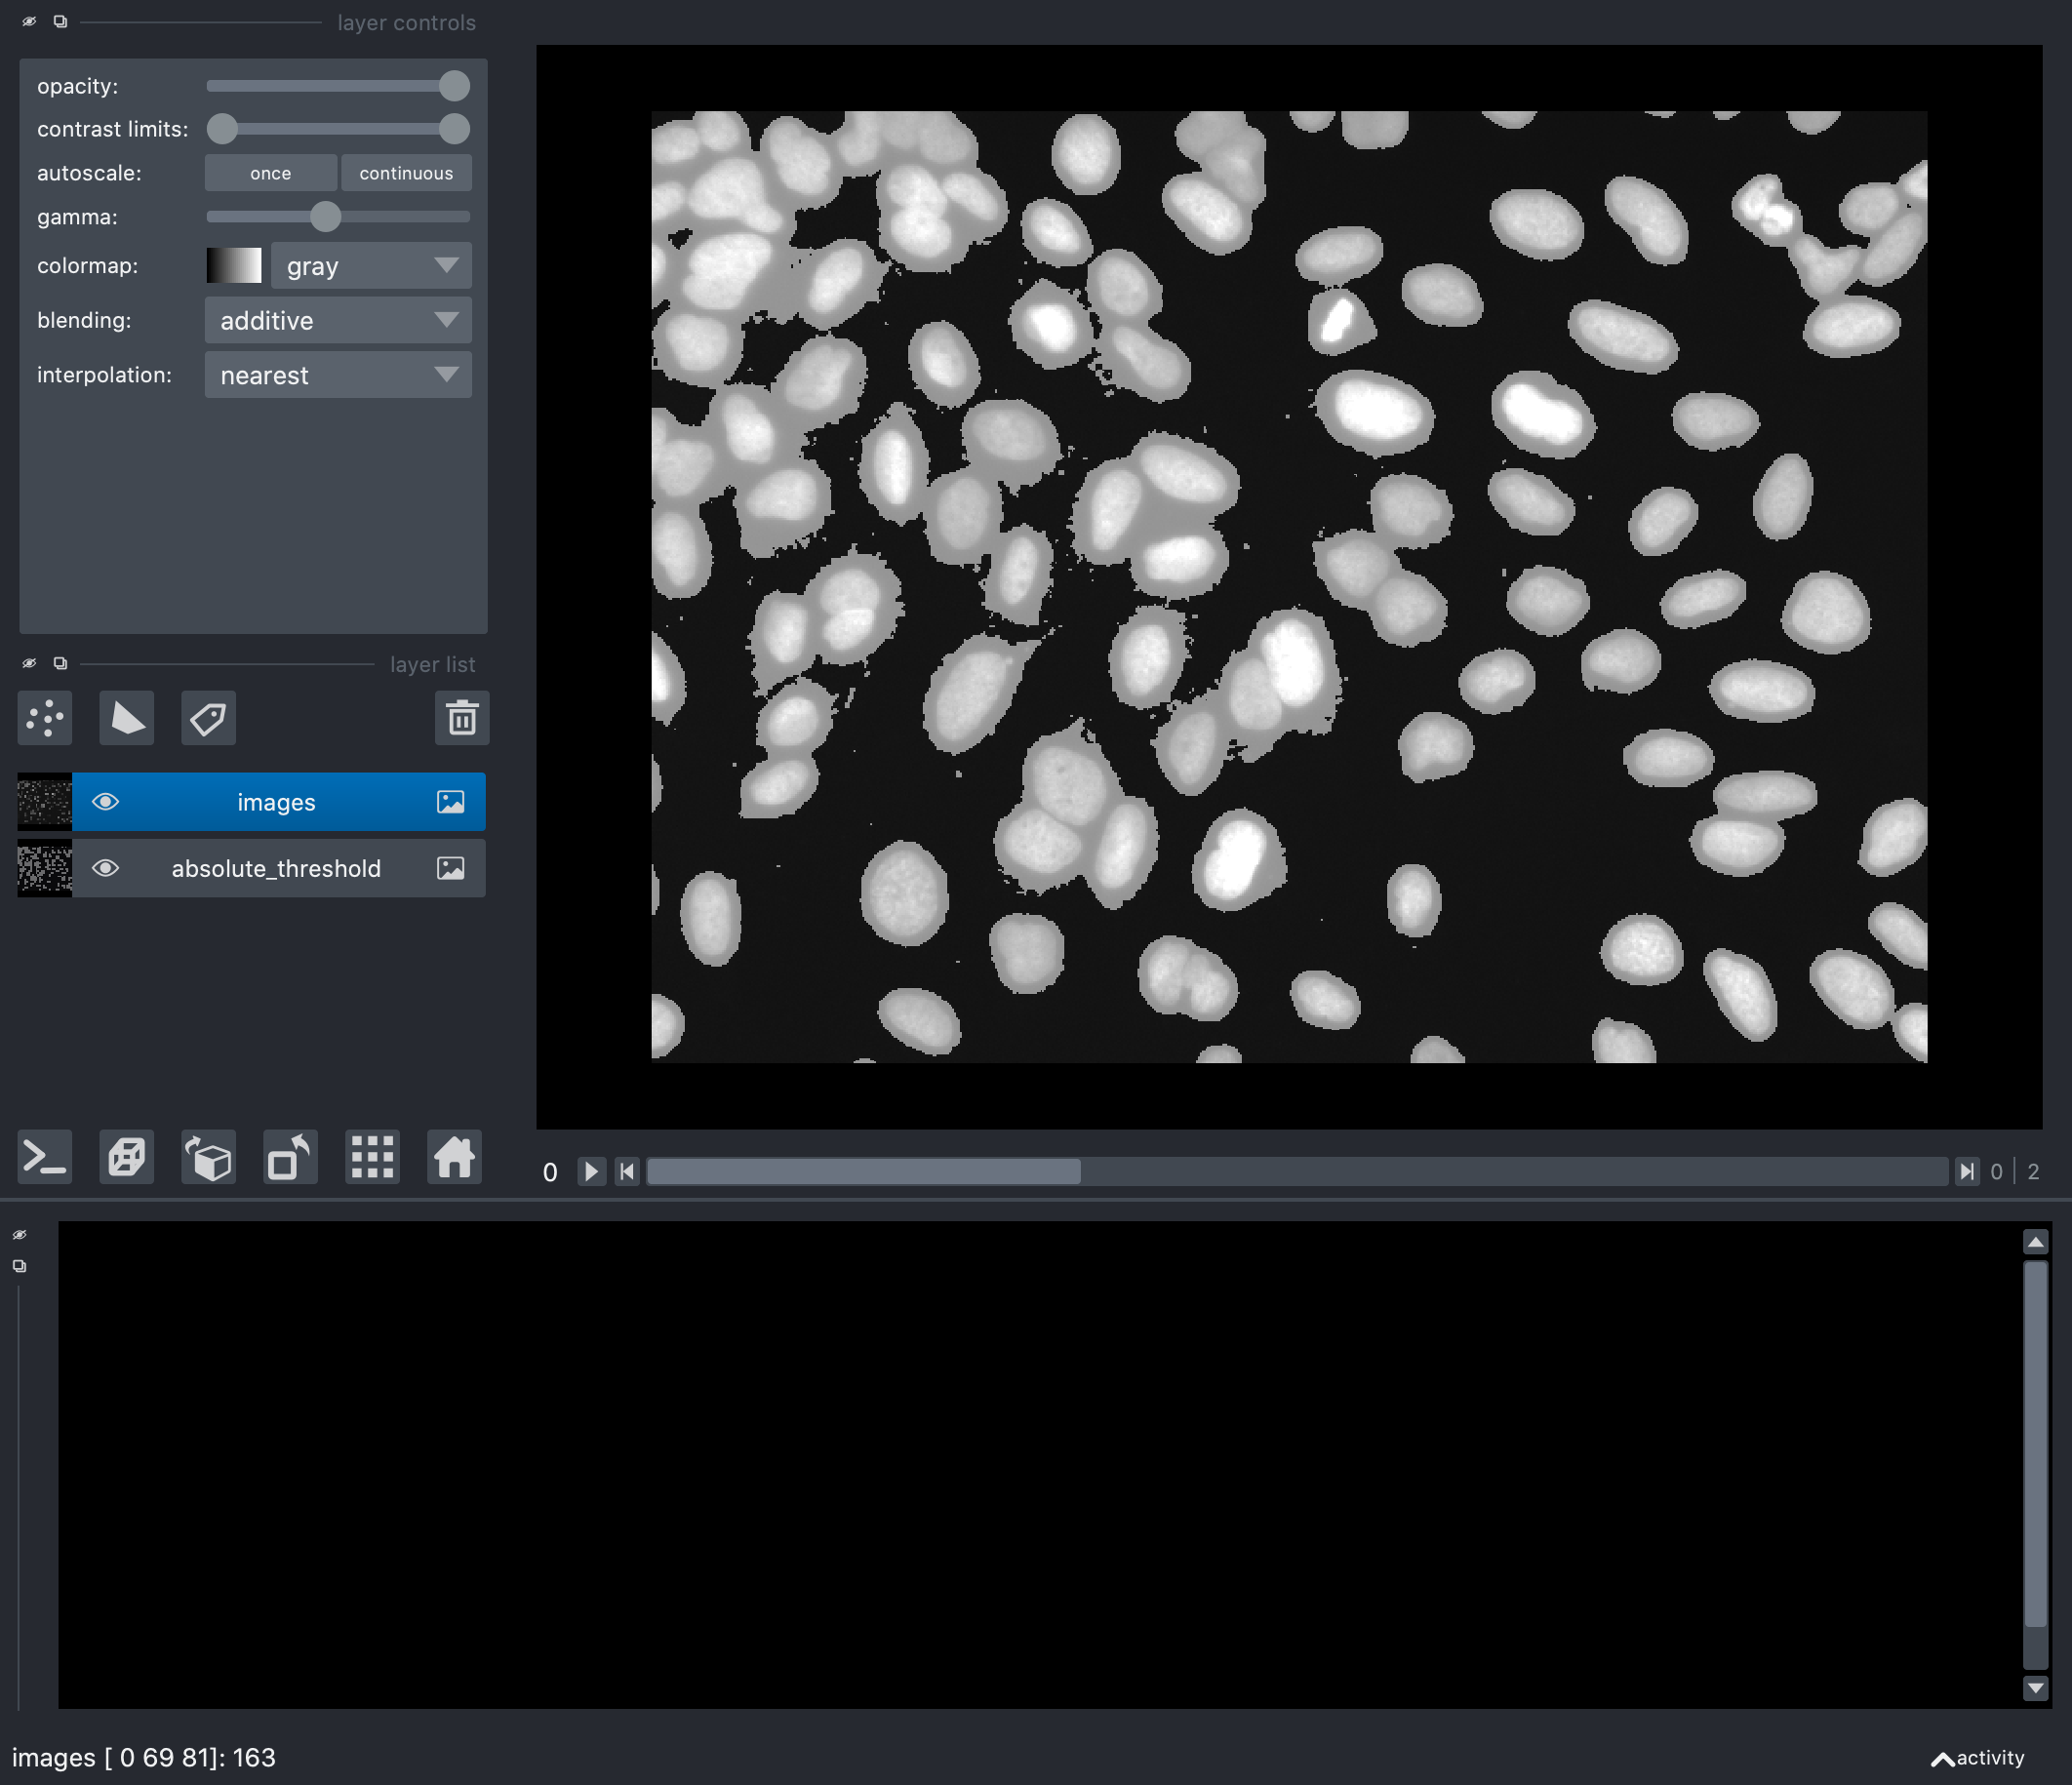

In [4]:
from napari.utils import nbscreenshot
nbscreenshot(viewer)

Instead, let's try a local threshold instead (https://image.dask.org/en/2021.12.0/dask_image.ndfilters.html?highlight=threshold_local#dask_image.ndfilters.threshold_local)

In [10]:
thresh = ndfilters.threshold_local(image = smoothed, block_size = images.chunksize)
threshold_images = smoothed > thresh                            # images.chunksize is (1, 520, 696), one image 

Let's get rid of our old layers

In [11]:
def removeLayers():
    layers = viewer.layers
    while len(layers) > 0:
        layers.remove(layers[0])    

removeLayers()

And visualize our new threshold. Much better!

In [12]:
viewer.add_image(threshold_images, opacity = 0.5)
viewer.add_image(images, contrast_limits=[0, 2000], blending='additive')

<Image layer 'images' at 0x1b446c190>

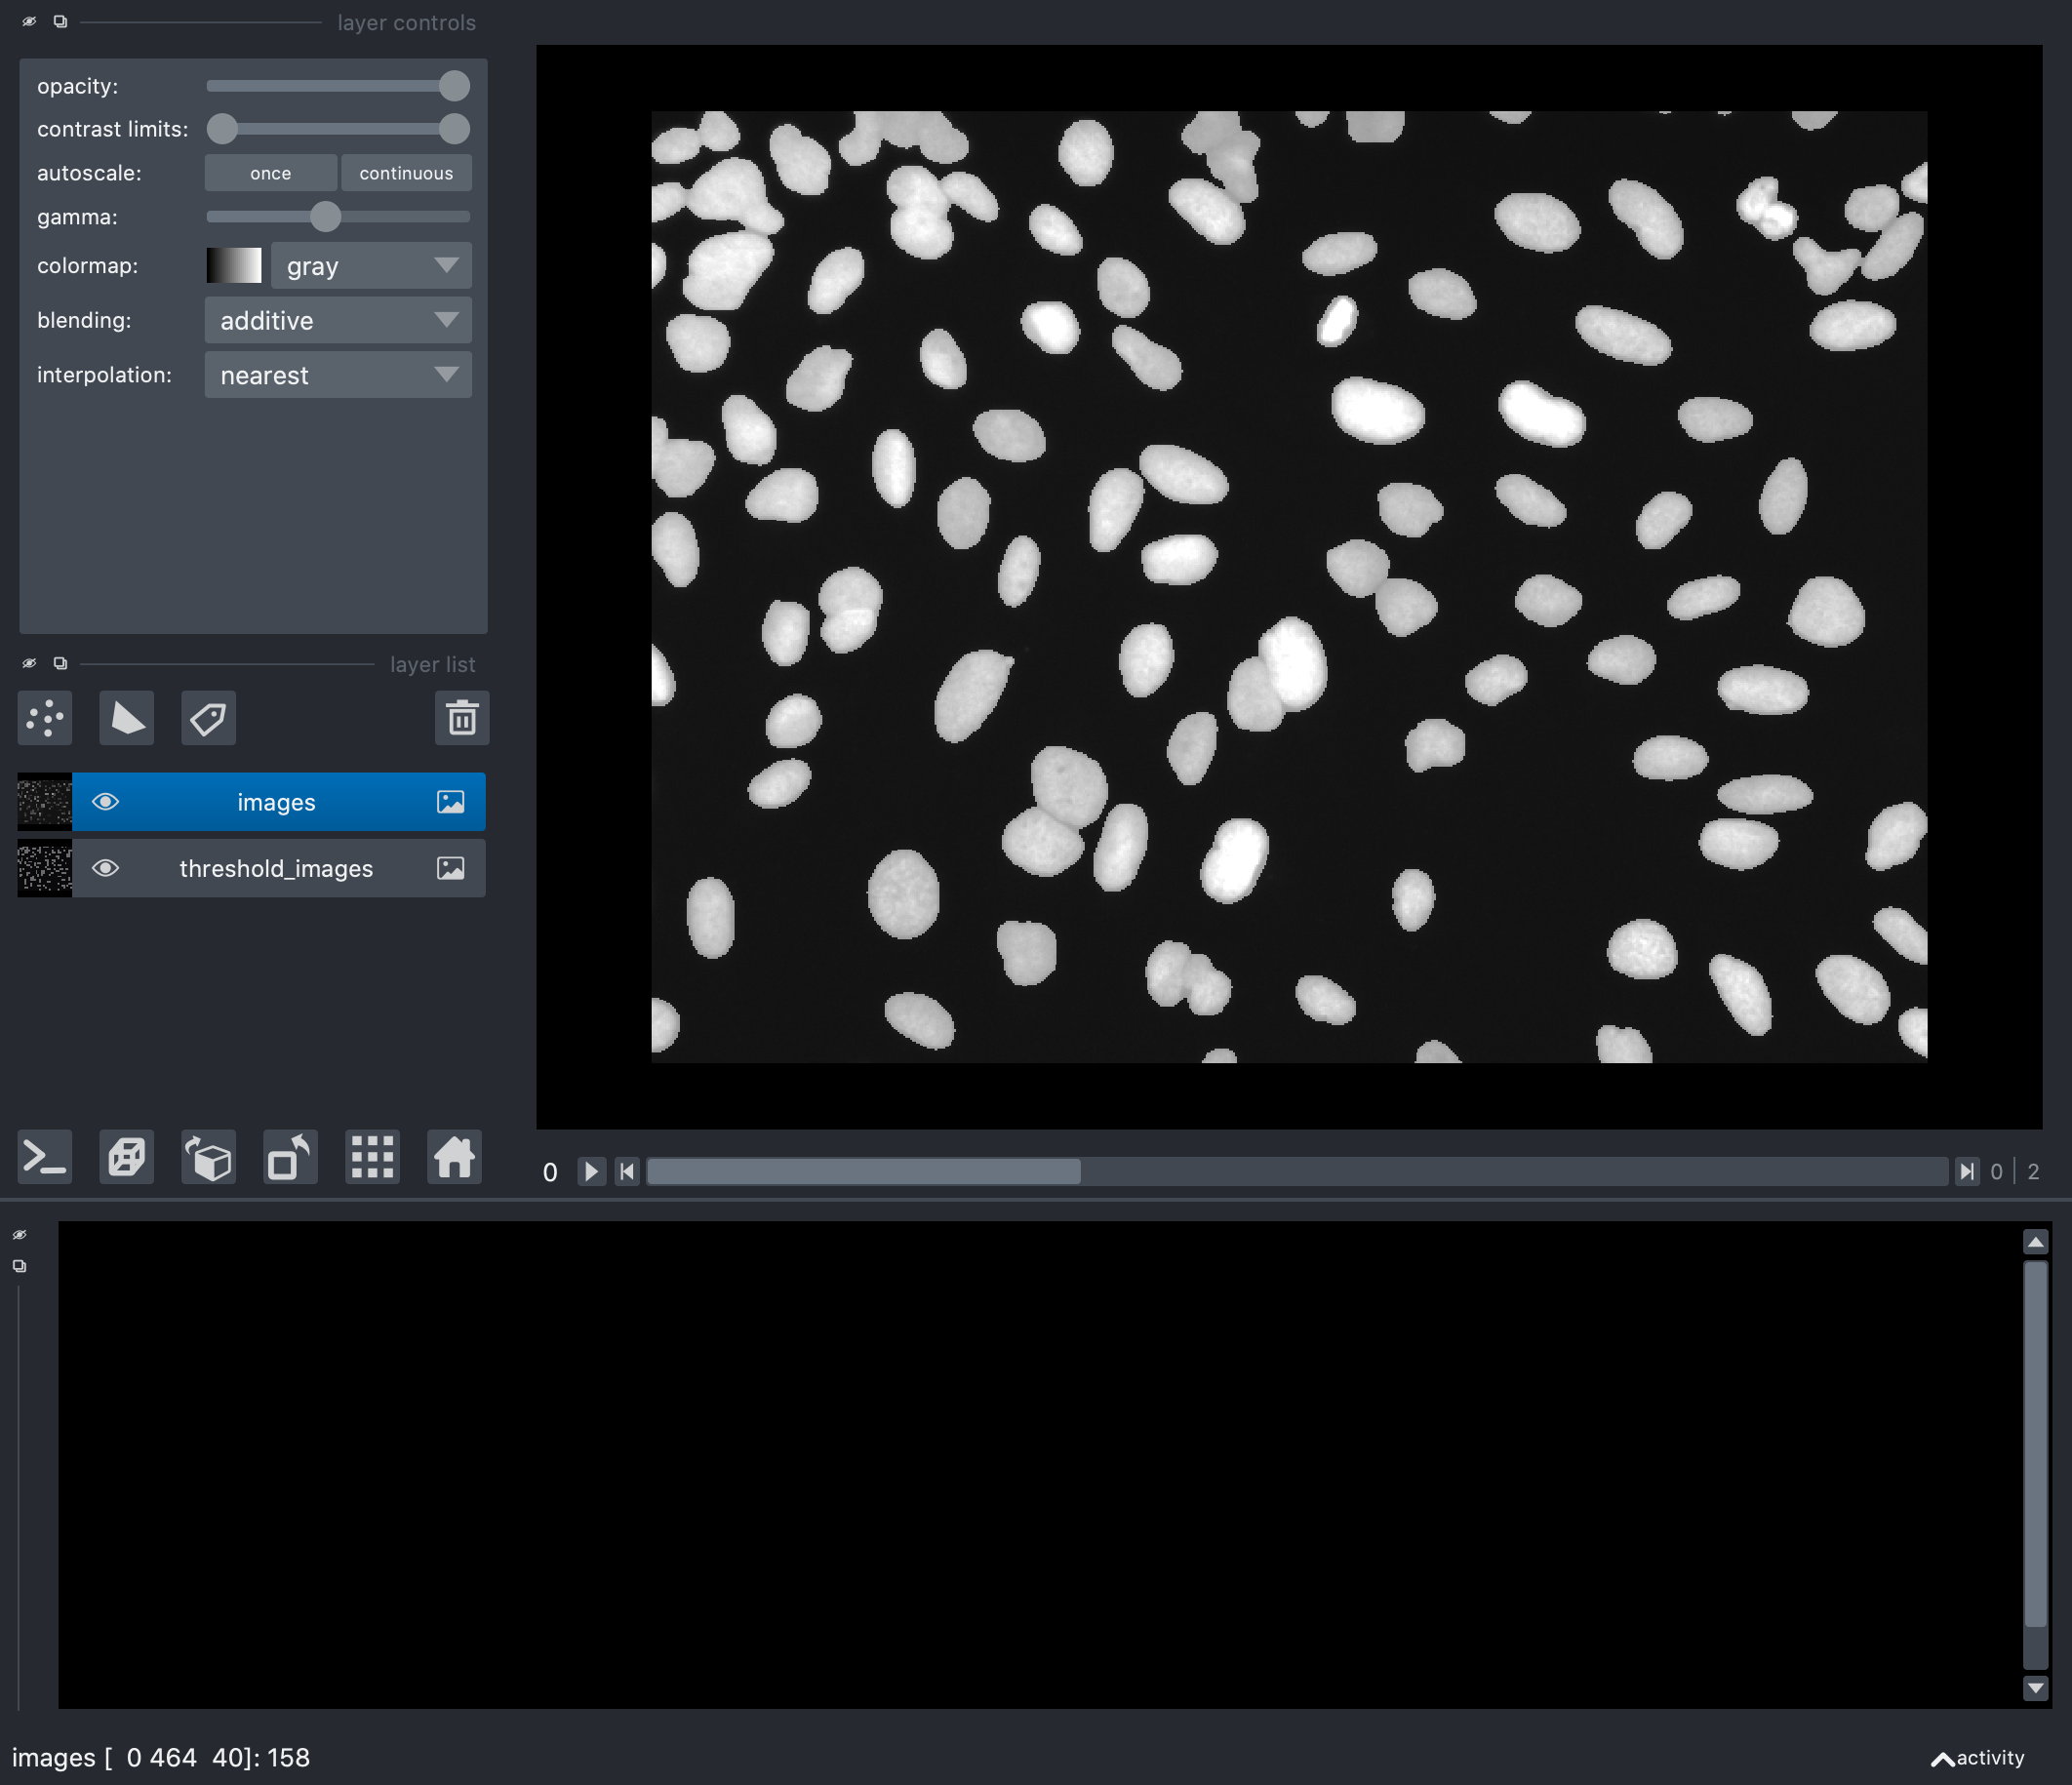

In [13]:
from napari.utils import nbscreenshot
nbscreenshot(viewer)

Let's clean up our threshold by running a binary "opening" (erosion followed by dilation) http://image.dask.org/en/latest/dask_image.ndmorph.html#dask_image.ndmorph.binary_opening

NOTE: Dask apparently does not support watershedding...

In [14]:
from dask_image import ndmorph
import numpy as np

structuring_element = np.array([        # this is equivalent to the defaults 2D structuring element, so we don't influence neighboring slices in our array
    [[0, 0, 0], [0, 0, 0], [0, 0, 0]],  # [[0, 1, 0],
    [[0, 1, 0], [1, 1, 1], [0, 1, 0]],  #  [1, 1, 1],
    [[0, 0, 0], [0, 0, 0], [0, 0, 0]]]) #  [0, 1, 0]]

binary_images = ndmorph.binary_opening(threshold_images, structure=structuring_element)

In [15]:
viewer.add_image(binary_images)

<Image layer 'binary_images' at 0x1b3993820>

Let's create labels for the binary features so we can analyze them 

In [18]:
from dask_image import ndmeasure

# Create labelled mask
label_images, num_features = ndmeasure.label(binary_images, structuring_element)
index = np.arange(num_features - 1) + 1 
viewer.add_labels(label_images)

<Labels layer 'label_images' at 0x1bc93d250>

Now each feature is labeled and can be analyzed independently

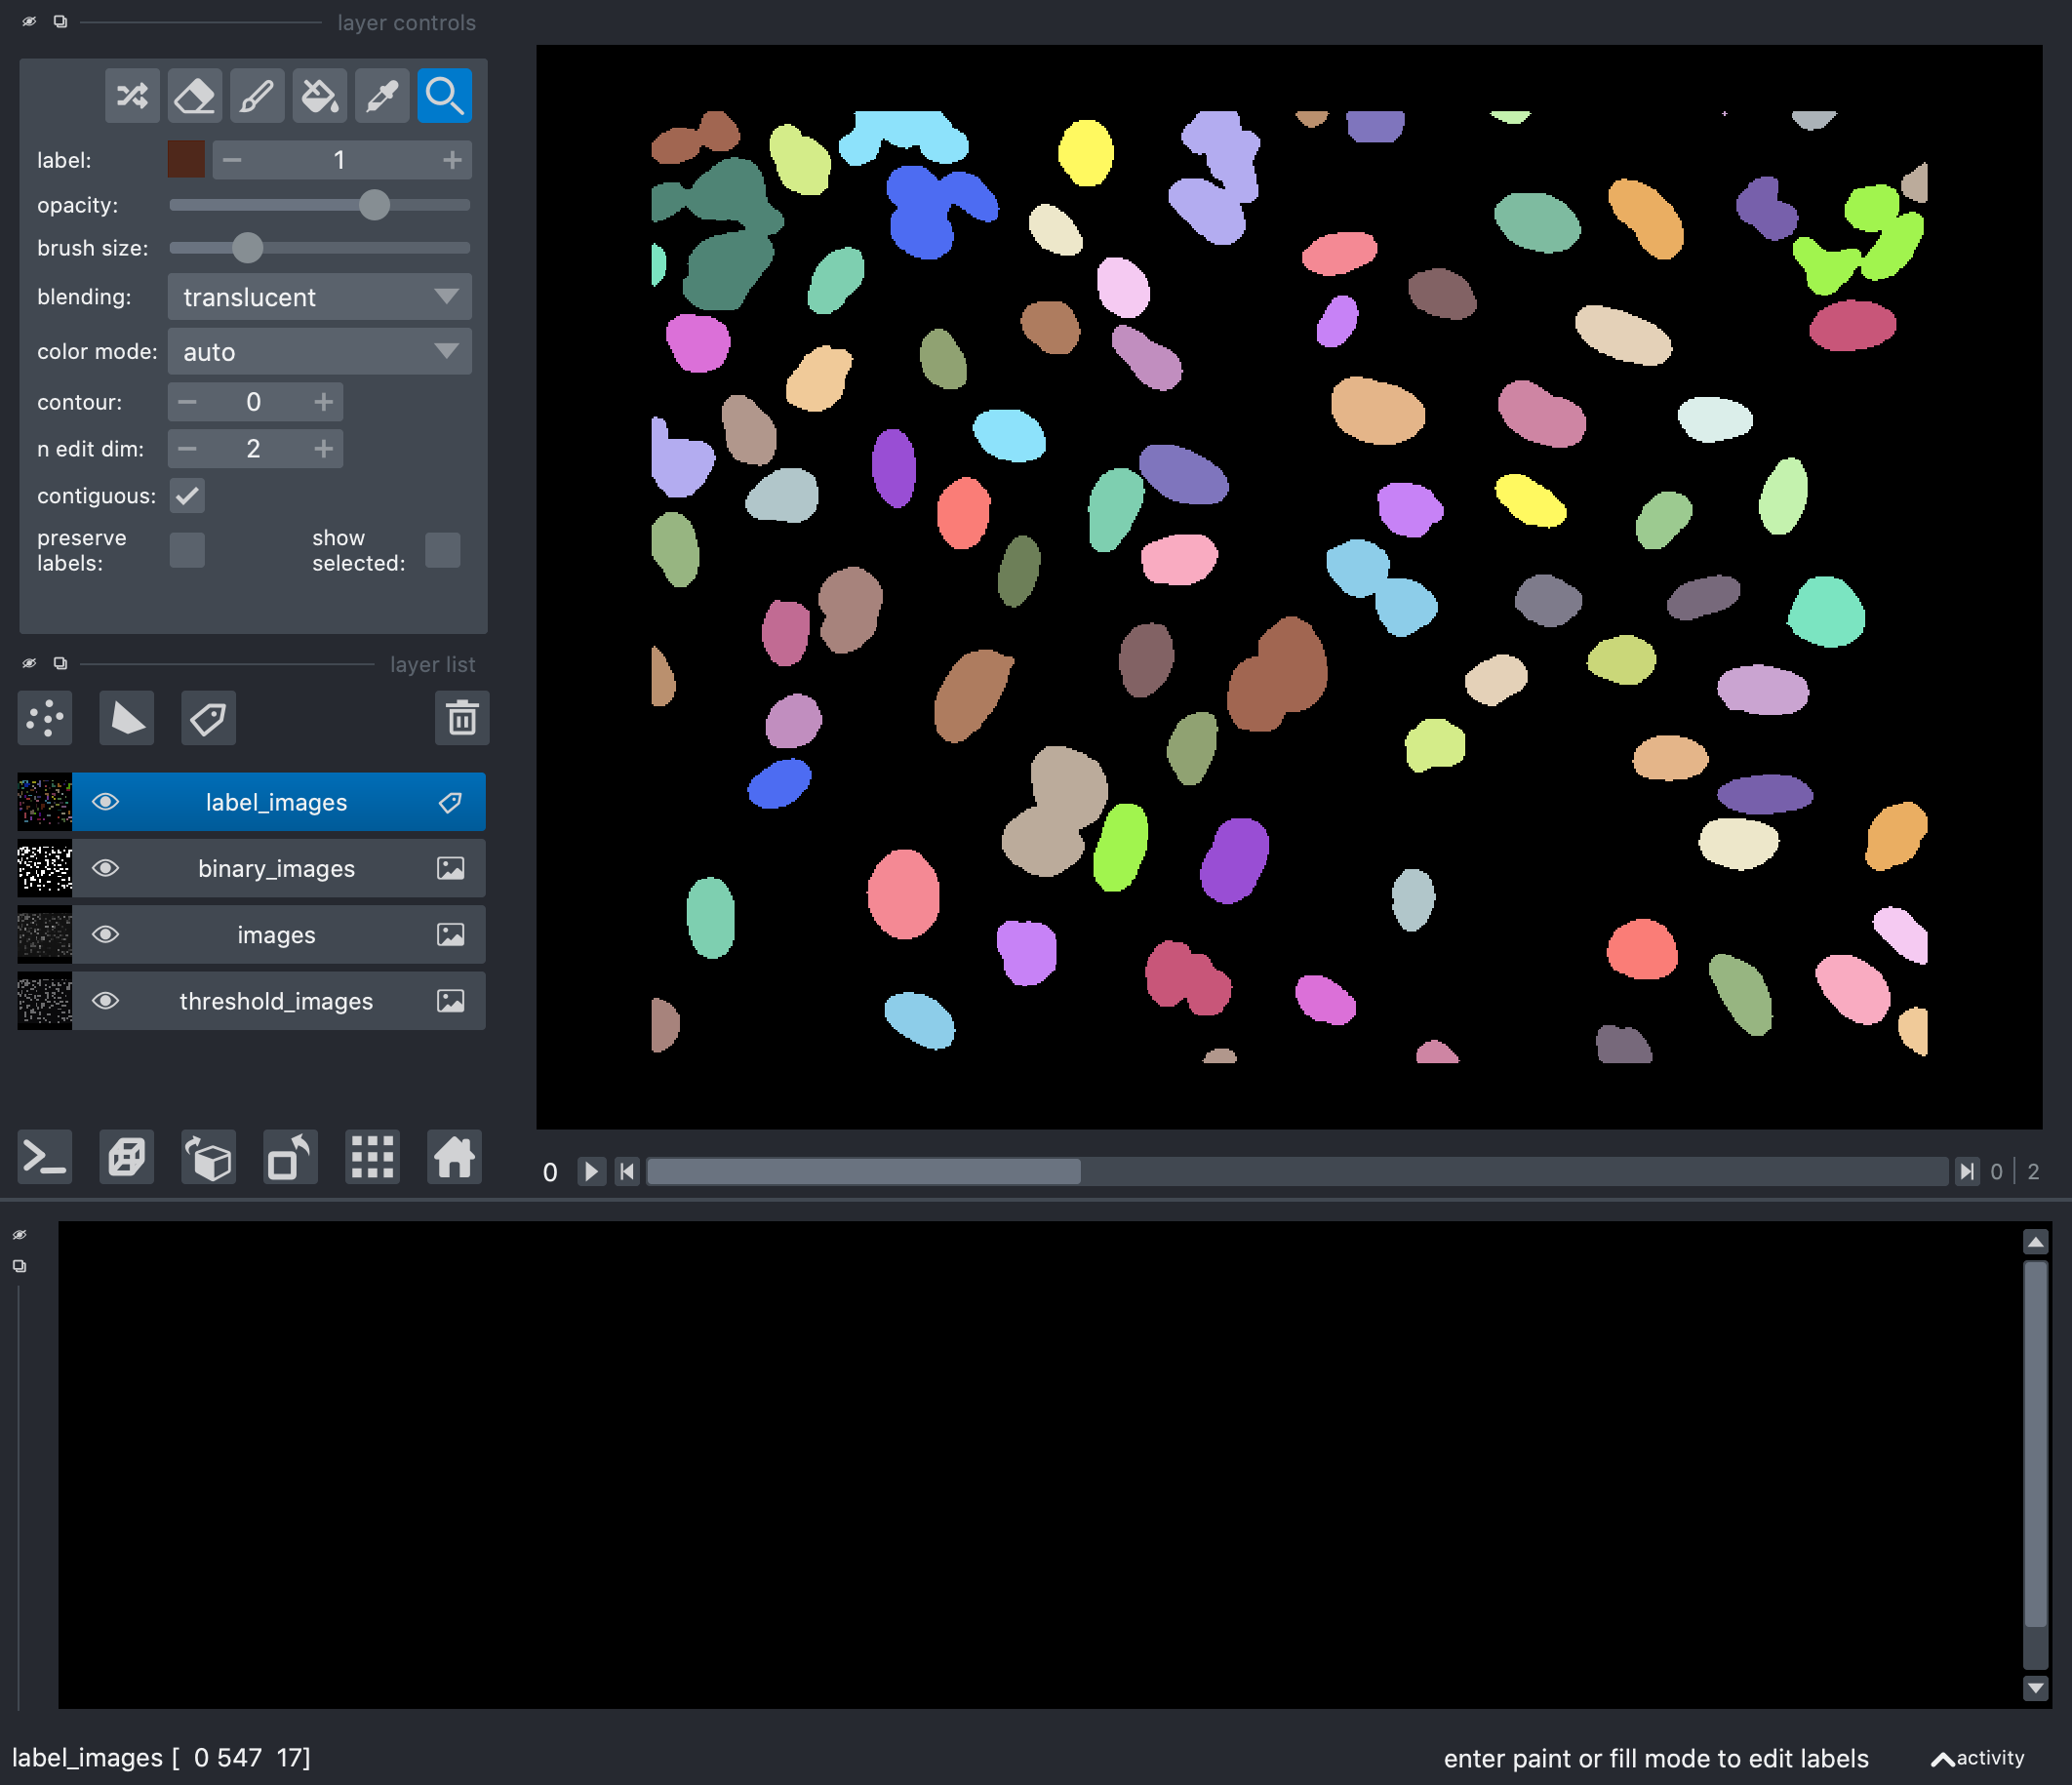

In [20]:
from napari.utils import nbscreenshot
nbscreenshot(viewer)

Let's count how many nuclei we have thresholded

In [21]:
print("Number of nuclei:", num_features.compute())

Number of nuclei: 271


We can also make measurements like area and mean intensity

In [22]:
area = ndmeasure.area(images, label_images, index)
mean_intensity = ndmeasure.mean(images, label_images, index)

Which we can plot interactively

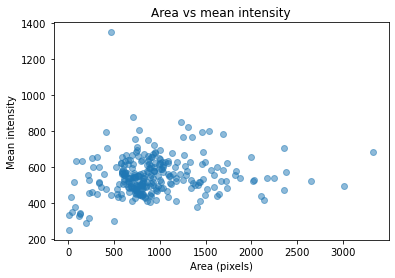

In [23]:
import matplotlib.pyplot as plt

plt.scatter(area, mean_intensity, alpha=0.5)
plt.gca().update(dict(title="Area vs mean intensity", xlabel='Area (pixels)', ylabel='Mean intensity'))
plt.show()